In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyeem

In [2]:
pyeem.instruments.supported

name
manufacturer supported_models              
Agilent      Cary 4E                cary_4e
             Cary Eclipse      cary_eclipse
Horiba       Aqualog-880-C          aqualog
             SPEX Fluorolog-3     fluorolog
Tecan        Spark                    spark

In [3]:
data_dir = "../../../../local_test_data/cells"
#data_dir = "../../../../local_test_data/pigment_calibration"

#data_dir = "../../../../local_test_data/pigment_data"
calibration_sources = {
    "chlorella": "cells/mL",
    "microcystis": "cells/mL",
}
"""
calibration_sources = {
    "chloropyhll": "ug/L",
    "phycocyanin": "ug/L",
}
"""
# "fucoxanthin": "ug/L"

dataset = pyeem.datasets.Dataset(
    data_dir=data_dir,
    calibration_sources=calibration_sources,
    raman_instrument="cary_eclipse",
    absorbance_instrument="cary_eclipse",
    eem_instrument="cary_eclipse",
    mode="w"
)

In [4]:
display(dataset.meta_df)

datetime_utc          filename description comments  \
sample_set scan_type                                                         
1          sample_eem    2020-06-04   sample_eem1.csv                        
           sample_eem    2020-06-05   sample_eem2.csv                        
           sample_eem    2020-06-06   sample_eem3.csv                        
           sample_eem    2020-06-07   sample_eem4.csv                        
           sample_eem    2020-06-08   sample_eem5.csv                        
...                             ...               ...         ...      ...   
10         sample_eem    2020-09-01   sample_eem4.csv                        
           sample_eem    2020-09-02   sample_eem5.csv                        
           blank_eem     2020-09-03    blank_eem1.csv  freshwater            
           water_raman   2020-09-04  water_raman1.csv         275            
           water_raman   2020-09-05  water_raman2.csv         350            

                       collected_by  water_raman_wavelength  dilution_factor  \
sample_set scan_type                                                           
1          sample_eem        Qinmin                     NaN              1.0   
           sample_eem        Qinmin                     NaN              1.0   
           sample_eem        Qinmin                     NaN              1.0   
           sample_eem        Qinmin                     NaN              1.0   
           sample_eem        Qinmin                     NaN              1.0   
...                             ...                     ...              ...   
10         sample_eem        Qinmin                     NaN              1.0   
           sample_eem        Qinmin                     NaN              1.0   
           blank_eem         Qinmin                     NaN              1.0   
           water_raman       Qinmin                   275.0              1.0   
           water_raman       Qinmin                   350.0              1.0   

                        chlorophyll  phycocyanin  fucoxanthin  chlorella  \
sample_set scan_type                                                       
1          sample_eem         500.0          NaN          NaN        0.0   
           sample_eem         800.0          NaN          NaN        0.0   
           sample_eem        1000.0          NaN          NaN        0.0   
           sample_eem        2000.0          NaN          NaN        0.0   
           sample_eem        5000.0          NaN          NaN        0.0   
...                             ...          ...          ...        ...   
10         sample_eem           NaN          NaN          NaN        0.0   
           sample_eem           NaN          NaN          NaN        0.0   
           blank_eem            NaN          NaN          NaN        0.0   
           water_raman          NaN          NaN          NaN        0.0   
           water_raman          NaN          NaN          NaN        0.0   

                        microcystis  calibration_sample  prototypical_sample  \
sample_set scan_type                                                           
1          sample_eem           0.0               False                False   
           sample_eem           0.0               False                False   
           sample_eem           0.0               False                False   
           sample_eem           0.0               False                False   
           sample_eem           0.0               False                False   
...                             ...                 ...                  ...   
10         sample_eem     1711581.0                True                False   
           sample_eem     3423161.0                True                False   
           blank_eem            0.0               False                False   
           water_raman          0.0               False                False   
           water_r

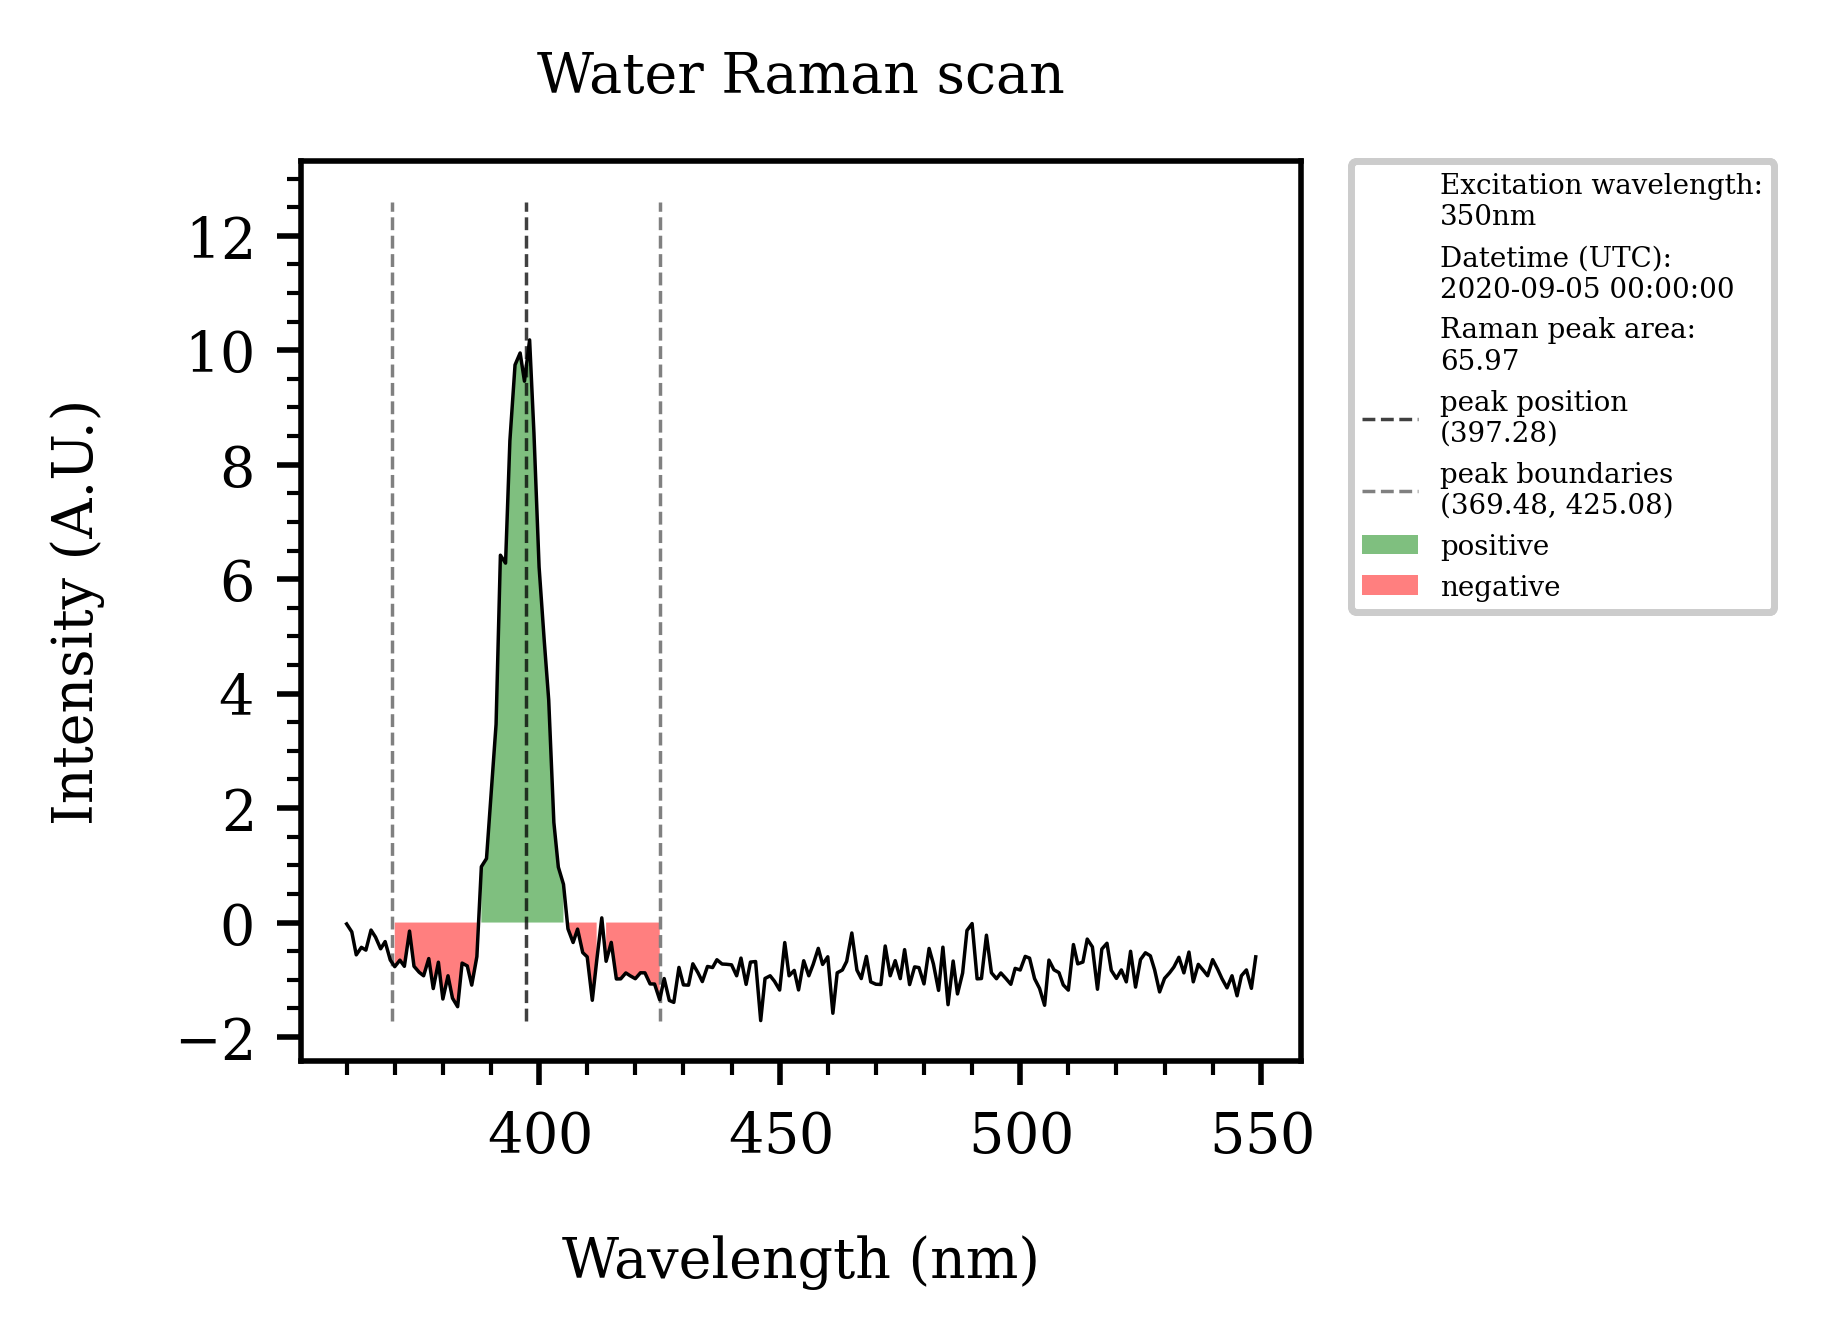

In [5]:
from IPython.display import HTML
anim = pyeem.plots.water_raman_peak_animation(dataset, excitation_wavelength=350)
HTML(anim.to_html5_video())

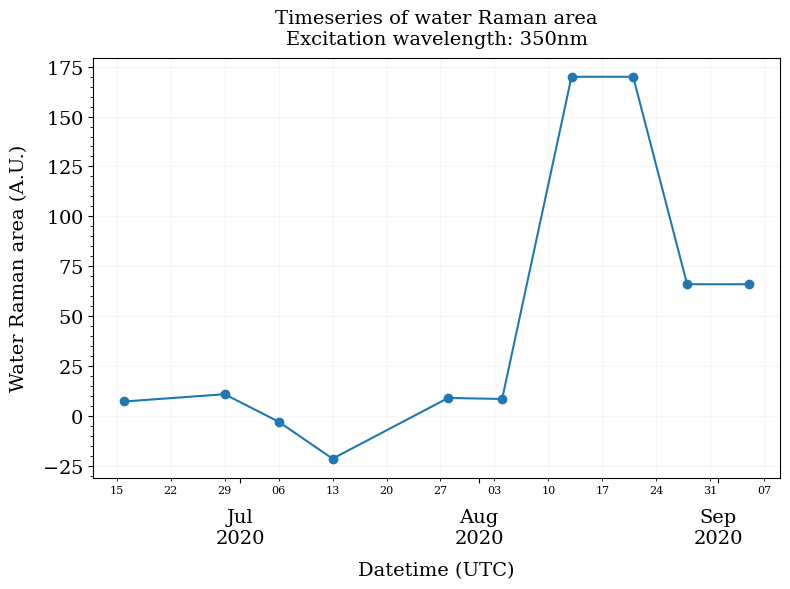

In [13]:
fig_kws = {"dpi": 100}
plot_kws = {"fmt": "o-"}
kwargs = {"byweekday":(0)}
ax = pyeem.plots.water_raman_timeseries(
    dataset,
    excitation_wavelength=350,
    fig_kws=fig_kws,
    plot_kws=plot_kws,
    **kwargs
)
plt.show()

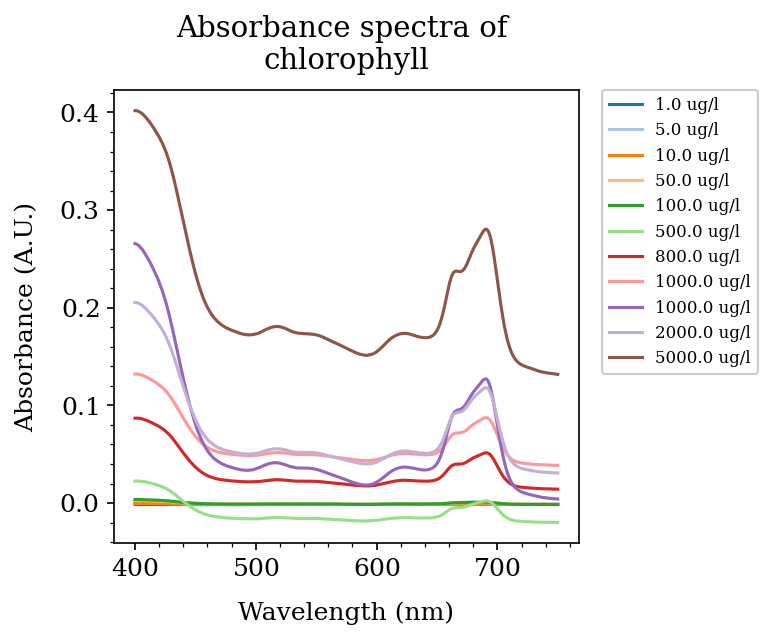

In [14]:
from cycler import cycler

fig = plt.figure(dpi=150)
ax = plt.gca()
ax.set_prop_cycle(cycler(color=plt.get_cmap('tab20').colors))

pigment = "chlorophyll"
absorb_meta_df = dataset.meta_df.xs("absorb", level="scan_type")
absorb_meta_df = absorb_meta_df[absorb_meta_df[pigment].notna()]

for index, row in absorb_meta_df.sort_values(pigment).iterrows():
    absorb_df = pd.read_hdf(dataset.hdf, key=row["hdf_path"])
    plot_kws = {
        "label": str(row[pigment]) + " ug/l",
    }
    kwargs = {
        "title": "Absorbance spectra of \n%s" % pigment
    }
    ax = pyeem.plots.absorbance_plot(
        absorb_df,
        wavelength_bounds=(400,750),
        ax=ax,
        fig_kws={"dpi":100},
        plot_kws=plot_kws,
        **kwargs
    )

ax.legend(
    fontsize=8,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.0,
)
plt.show()

#df = pd.read_hdf(dataset.hdf, key="raw_sample_sets/1/absorb1")
#ax = pyeem.plots.absorbance_plot(df)
#plt.show()

In [15]:
routine_df = pyeem.preprocessing.create_routine(
    crop=True,
    blank_subtraction=True,
    scatter_removal=True,
    inner_filter_effect=True,
    raman_normalization=True,
    gaussian_smoothing=True
)
display(routine_df)

,step_name,hdf_path
step_order,,
0,raw,raw_sample_sets/
1,crop,preprocessing/filters/crop
2,blank_subtraction,preprocessing/corrections/blank_subtraction
3,inner_filter_effect,preprocessing/corrections/inner_filter_effect
4,raman_normalization,preprocessing/corrections/raman_normalization
5,scatter_removal,preprocessing/corrections/scatter_removal
6,gaussian_smoothing,preprocessing/filters/gaussian_smoothing
7,complete,preprocessing/complete/


In [ ]:
# Keep everything
#crop_dims = {"emission_bounds": (-np.inf, np.inf), "excitation_bounds": (-np.inf, np.inf)}

# microcystis peak
#crop_dims = {"emission_bounds": (640, 650),"excitation_bounds": (610, 630)}

# chlorella peak
crop_dims = {"emission_bounds": (600, 800),"excitation_bounds": (-np.inf, 720)}

# fuco. peak
#crop_dims = {"emission_bounds": (600, 800),"excitation_bounds": (-np.inf, 600)}

kwargs = {
    "crop_dims": crop_dims,
    "band": "rayleigh",
    "order": "both",
    "excision_width": 50,
    "fill": "interp",
    "raman_source_type": "water_raman",
    "water_raman_wavelength": 275,
    "limit": 3
}

routine_results_df = pyeem.preprocessing.perform_routine(
    dataset, routine_df, progress_bar=True, **kwargs
)
display(routine_results_df)

In [ ]:
display(routine_results_df[
    routine_results_df["step_exception"].notna()
])

In [ ]:
for group_name, group in dataset.meta_df.groupby(["sample_set", "name"]):
    """
    if not (
        group[dataset.calibration_sources.keys()].values[0][0] and 
        group[dataset.calibration_sources.keys()].values[0][1]
    ):
        continue
    """
    if group[group["calibration_sample"]].empty:
        continue
    """
    if not (
        group[dataset.calibration_sources.keys()].values[0][0]
    ):
        continue
    """
    sample_set = group_name[0]
    sample_name = group_name[1]
    if "sample_eem" not in sample_name:
        continue

    # Custom suptitle for the plot to be passed as kwarg
    title = dict(zip(
        dataset.calibration_sources.keys(),
        group[dataset.calibration_sources.keys()].values[0]
    ))
    suptitle = "Results of Preprocessing Routine - Sample Set #{0}\nSample name: {1}".format(
        sample_set, sample_name
    )
    suptitle += "\n" + str(title)

    pyeem.plots.preprocessing.preprocessing_routine_plot(
        dataset, 
        routine_results_df,
        sample_set,
        sample_name,
        plot_type="imshow",
        include_complete=False,
        suptitle = suptitle,
        fig_kws={"dpi": 150}
    )
    plt.show()

In [ ]:
cal_df = pyeem.preprocessing.calibration(
    dataset, routine_results_df
)
display(cal_df)

In [ ]:
cal_summary_df = pyeem.preprocessing.calibration_summary_info(
    cal_df
)
display(cal_summary_df)

In [ ]:
axes = pyeem.plots.calibration_curves_plot(
    dataset, cal_df, fig_kws={"figsize":(16,6), "dpi": 150}
)
"""
axes = pyeem.plots.calibration_curves_plot(
    dataset, cal_df, fig_kws={"dpi": 150}
)
"""
plt.show()

In [ ]:
proto_results_df = pyeem.augmentation.create_prototypical_spectra(
    dataset,
    cal_df
)
display(proto_results_df)

In [ ]:
axes = pyeem.plots.prototypical_spectra_plot(
    dataset,
    proto_results_df,
    plot_type="contour",
    fig_kws={"dpi": 300}
)
plt.show()

In [ ]:
ss_results_df = pyeem.augmentation.create_single_source_spectra(
    dataset,
    cal_df,
    conc_range=(800, 5000),
    num_spectra=1000
)
display(ss_results_df)

In [ ]:
from IPython.display import HTML
%matplotlib inline

source = "phycocyanin"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df.iloc[::500, :],
    source=source,
    plot_type="imshow",
    fig_kws={"dpi": 175},
    animate_kws={"interval": 100, "blit": True},
)
HTML(anim.to_html5_video())

In [ ]:
source = "chloropyhll"
anim = pyeem.plots.single_source_animation(
    dataset,
    ss_results_df.iloc[::500, :],
    source=source,
    plot_type="imshow",
    fig_kws={"dpi": 175},
    animate_kws={"interval": 100, "blit": True},
)
HTML(anim.to_html5_video())

## Augmented Spectra - Mixtures
### Create augmented mixture spectra by scaling and combining the prototypical spectra across a range of concentrations

In [ ]:
mix_results_df = pyeem.augmentation.create_mixture_spectra(
    dataset,
    cal_df,
    conc_range=(800, 5000),
    num_steps=15,
    scale="linear"
)
display(mix_results_df)

## Plot the augmented mixture spectra

In [ ]:
anim = pyeem.plots.mixture_animation(
    dataset,
    mix_results_df.iloc[::150, :],
    plot_type="imshow",
    fig_kws={"dpi": 175},
    animate_kws={"interval": 100, "blit": True},
)
HTML(anim.to_html5_video())

In [ ]:
rutherfordnet = pyeem.analysis.models.RutherfordNet()
rutherfordnet.create_model(input_shape=[201, 85, 1], output_dense_units=2)
rutherfordnet.model.summary()

In [ ]:
(x_train, y_train), (x_test, y_test) = rutherfordnet.prepare_data(
    dataset,
    ss_results_df,
    mix_results_df,
    routine_results_df
)

In [ ]:
history = rutherfordnet.train(
    x_train,
    y_train
)

In [ ]:
axes = pyeem.plots.model_history_plot(history)
plt.show()

In [ ]:
train_predictions = rutherfordnet.model.predict(x_train)
test_predictions = rutherfordnet.model.predict(x_test)

train_pred_results_df = rutherfordnet.get_prediction_results(
    dataset,
    train_predictions,
    y_train
)

test_pred_results_df = rutherfordnet.get_prediction_results(
    dataset,
    test_predictions,
    y_test
)

axes = pyeem.plots.prediction_parity_plot(
    dataset,
    test_pred_results_df,
    train_df=train_pred_results_df
)
plt.show()

In [ ]:
data_dir = "../../../../local_test_data/early_test_tecan/tecan_raw"

In [ ]:
metadata_fp = os.path.join(data_dir, "metadata.csv")
meta_df = pd.read_csv(metadata_fp)

In [ ]:
import numpy as np

for name, group in meta_df.groupby("filename"):
    fp = os.path.join(data_dir, name)
    # Read in raw Tecan Spark data with index column equal to zero
    # and skipping the last row of data which contains End Time
    df = pd.read_excel(fp, index_col=0, skipfooter=1)
    # Drop columns and rows with all NaN values, these sometimes
    # appear at the end for some reason
    df.dropna(how="all", axis=1, inplace=True)
    df.dropna(how="all", axis=0, inplace=True)
    group["next_well"] = group['well_id'].shift(-1)

    for index, row in group.iterrows():
        display(row)
        tmp_df = df.loc[row["well_id"]:]
        if not pd.isna(row["next_well"]):
            tmp_df = df.loc[row["well_id"] : row["next_well"]].iloc[:-1]

        new_header = tmp_df.iloc[0] #grab the first row for the header
        tmp_df = tmp_df[1:] #take the data less the header row
        tmp_df.columns = new_header #set the header row as the df header
        tmp_df.index.name = None
        tmp_df.columns.name = None
        display(tmp_df.head())
